In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train['LeadStatus'] = train['LeadStatus'].replace({"Passed":0, "Flagged":1, "Assign to CS":1})
test['LeadStatus'] = test['LeadStatus'].replace({"Passed":0, "Flagged":1, "Assign to CS":1})
# train = train.drop(train[train['Country'] == 'ERROR'].index)
# test = test.drop(test[test['Country'] == 'ERROR'].index)

In [3]:
def compare_last(row):
    pId = row['PatientID']
    # get all records of the same patient and sort by visit day.
    patient = train[train.PatientID == pId].sort_values(by='VisitDay', ascending=True).reset_index(drop=True)
    if patient.shape[0] == 0:
        patient = test[test.PatientID == pId].sort_values(by='VisitDay', ascending=True).reset_index(drop=True)
    # get the index of the record that current row represents
    current = patient[patient.VisitDay == row['VisitDay']].index.values[0]
    if current == 0: # if it's the first time visiting
        return 0
    else: # return the difference between the current panss total and last time panss total.
        return row['PANSS_Total'] - patient.loc[current-1,'PANSS_Total']
    

train_comp_last = train.copy()
test_comp_last = test.copy()
train_comp_last['TotalCompareLastTime'] = train_comp_last.apply(compare_last, axis=1)
test_comp_last['TotalCompareLastTime'] = test_comp_last.apply(compare_last, axis=1)

In [4]:
X_train = train.iloc[:, 7:38]
X_test = test.iloc[:, 7:38]

y_train = train['LeadStatus']
y_test = test['LeadStatus']

X_colnames = train.columns[7:38]
X_train_org = train.values[:, 7:38]
X_test_org = test.values[:, 7:38]

X_train_delta = pd.concat([X_train,train_comp_last.TotalCompareLastTime], axis=1)
X_test_delta = pd.concat([X_test,test_comp_last.TotalCompareLastTime], axis=1)


# upsamling minority class
X = pd.concat([X_train, y_train], axis=1)

not_fraud = X[X['LeadStatus']==0]
fraud = X[X['LeadStatus']==1]

fraud_upsampled = resample(fraud,
                           replace=True, # sample with replacement
                           n_samples=len(not_fraud), # match number in majority class
                           random_state=27) # reproducible results
upsampled = pd.concat([not_fraud, fraud_upsampled])
y_train_upsampled = upsampled.LeadStatus
X_train_upsampled = upsampled.drop('LeadStatus', axis=1)

X = pd.concat([X_train_delta, y_train], axis=1)

not_fraud = X[X['LeadStatus']==0]
fraud = X[X['LeadStatus']==1]

fraud_upsampled = resample(fraud,
                           replace=True, # sample with replacement
                           n_samples=len(not_fraud), # match number in majority class
                           random_state=27) # reproducible results
upsampled = pd.concat([not_fraud, fraud_upsampled])
y_train_delta_upsampled = upsampled.LeadStatus
X_train_delta_upsampled = upsampled.drop('LeadStatus', axis=1)

# Standarization
ss_X = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.fit_transform(X_test)
X_test_delta = ss_X.fit_transform(X_test_delta)
X_train_upsampled = ss_X.fit_transform(X_train_upsampled)
X_train_delta = ss_X.fit_transform(X_train_delta)
X_train_delta_upsampled = ss_X.fit_transform(X_train_delta_upsampled)



#PCA
decomposer = PCA(n_components=20, random_state=42,)
X_train_comp = decomposer.fit_transform(X_train)
X_train_upsampled_comp = decomposer.fit_transform(X_train_upsampled)
X_test_comp = decomposer.fit_transform(X_test)

X_test_comp = X_test_comp[:,decomposer.explained_variance_ratio_>0.02]
X_train_comp = X_train_comp[:,decomposer.explained_variance_ratio_>0.02]
X_train_upsampled_comp = X_train_upsampled_comp[:,decomposer.explained_variance_ratio_>0.02]

In [5]:
print(X_train.shape)
print(X_train_upsampled.shape)
print(X_train_delta.shape)
print(X_train_delta_upsampled.shape)
print(X_test.shape)
print(X_test_delta.shape)

(16799, 31)
(25430, 31)
(16799, 32)
(25430, 32)
(4148, 31)
(4148, 32)


In [6]:
def fit_model(model, x_train, y_train, x_test, y_test):
    '''
    x_train: pd.DataFrame
    y_train: pd.Series
    return: None
    print: precision, recall, f1, accuracy
    '''
    from warnings import simplefilter
    import time
    simplefilter(action='ignore', category=FutureWarning)
    
    start = time.time()
    model.fit(x_train, y_train)
    stop = time.time()
    print('Training took {:3.2f} seconds.'.format(stop-start))
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))

In [34]:
model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'SVM', 'KNN']
models = [LogisticRegression(), GaussianNB(), RandomForestClassifier(), SVC(), KNeighborsClassifier(n_neighbors=5)]
print("Features: {}.\n".format(X_colnames))
print("standarization")
for i in range(len(model_names)):
    print(model_names[i])
    fit_model(models[i], X_train, y_train, X_test, y_test)

Features: Index(['VisitDay', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8',
       'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16'],
      dtype='object').

standarization
Logistic Regression
Training took 0.08 seconds.
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      3126
           1       0.62      0.10      0.17      1022

    accuracy                           0.76      4148
   macro avg       0.70      0.54      0.51      4148
weighted avg       0.73      0.76      0.69      4148

Naive Bayes
Training took 0.01 seconds.
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      3126
           1       0.40      0.41      0.40      1022

    accuracy                           0.70      4148
   macro avg       0.60      0.60      0.60      4148
weighted avg       0.70      0.70      0.70

In [102]:
model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'SVM', 'KNN']
models = [LogisticRegression(), GaussianNB(), RandomForestClassifier(), SVC(), KNeighborsClassifier(n_neighbors=5)]
print("Features: {}.\n".format(X_colnames))
print("delta")
for i in range(len(model_names)):
    print(model_names[i])
    fit_model(models[i], X_train_delta, y_train, X_test_delta, y_test)

Features: Index(['VisitDay', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8',
       'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16'],
      dtype='object').

delta
Logistic Regression
Training took 0.05 seconds.
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      3126
           1       0.62      0.10      0.17      1022

    accuracy                           0.76      4148
   macro avg       0.70      0.54      0.51      4148
weighted avg       0.73      0.76      0.69      4148

Naive Bayes
Training took 0.01 seconds.
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      3126
           1       0.40      0.41      0.40      1022

    accuracy                           0.70      4148
   macro avg       0.60      0.60      0.60      4148
weighted avg       0.71      0.70      0.70      414

In [101]:
model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'SVM', 'KNN']
models = [LogisticRegression(), GaussianNB(), RandomForestClassifier(), SVC(), KNeighborsClassifier(n_neighbors=5)]
print("Features: {}.\n".format(X_colnames))
print("delta and upsampling")
for i in range(len(model_names)):
    print(model_names[i])
    fit_model(models[i], X_train_delta_upsampled, y_train_upsampled, X_test_delta, y_test)

Features: Index(['VisitDay', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8',
       'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16'],
      dtype='object').

with delta and upsampling
Logistic Regression
Training took 0.07 seconds.
              precision    recall  f1-score   support

           0       0.84      0.56      0.67      3126
           1       0.33      0.67      0.44      1022

    accuracy                           0.58      4148
   macro avg       0.58      0.61      0.56      4148
weighted avg       0.71      0.58      0.61      4148

Naive Bayes
Training took 0.01 seconds.
              precision    recall  f1-score   support

           0       0.82      0.68      0.74      3126
           1       0.36      0.55      0.43      1022

    accuracy                           0.65      4148
   macro avg       0.59      0.61      0.59      4148
weighted avg       0.71      0.6

In [86]:
model_names = ['Logistic Regression', 'SVM']
models = [LogisticRegression(class_weight = {1:0.75,0:0.25}), SVC(class_weight = {1:0.75,0:0.25})]
print("Features: {}.\n".format(X_colnames))
print("Class Weight")
for i in range(len(model_names)):
    print(model_names[i])
    fit_model(models[i], X_train, y_train, X_test, y_test)

Features: Index(['VisitDay', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8',
       'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16'],
      dtype='object').

Class Weight
Logistic Regression
Training took 0.05 seconds.
              precision    recall  f1-score   support

           0       0.83      0.65      0.72      3126
           1       0.35      0.58      0.44      1022

    accuracy                           0.63      4148
   macro avg       0.59      0.61      0.58      4148
weighted avg       0.71      0.63      0.65      4148

SVM
Training took 11.73 seconds.
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      3126
           1       0.44      0.61      0.51      1022

    accuracy                           0.71      4148
   macro avg       0.64      0.68      0.65      4148
weighted avg       0.75      0.71      0.72      414

In [36]:
model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'SVM', 'KNN']
models = [LogisticRegression(), GaussianNB(), RandomForestClassifier(), SVC(), KNeighborsClassifier(n_neighbors=5)]
print("Features: {}.\n".format(X_colnames))
print("upsampled + standarization")
for i in range(len(model_names)):
    print(model_names[i])
    fit_model(models[i], X_train_upsampled, y_train_upsampled, X_test, y_test)

Features: Index(['VisitDay', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8',
       'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16'],
      dtype='object').

upsampled + standarization
Logistic Regression
Training took 0.07 seconds.
              precision    recall  f1-score   support

           0       0.84      0.56      0.67      3126
           1       0.33      0.67      0.44      1022

    accuracy                           0.59      4148
   macro avg       0.58      0.61      0.56      4148
weighted avg       0.71      0.59      0.61      4148

Naive Bayes
Training took 0.01 seconds.
              precision    recall  f1-score   support

           0       0.82      0.68      0.74      3126
           1       0.35      0.54      0.43      1022

    accuracy                           0.64      4148
   macro avg       0.59      0.61      0.58      4148
weighted avg       0.70      0.

In [37]:
model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'SVM', 'KNN']
models = [LogisticRegression(), GaussianNB(), RandomForestClassifier(), SVC(), KNeighborsClassifier(n_neighbors=5)]
print("Features: {}.\n".format(X_colnames))
print("PCA")
for i in range(len(model_names)):
    print(model_names[i])
    fit_model(models[i], X_train_comp, y_train, X_test_comp, y_test)

Features: Index(['VisitDay', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8',
       'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16'],
      dtype='object').

PCA
Logistic Regression
Training took 0.02 seconds.
              precision    recall  f1-score   support

           0       0.76      0.97      0.85      3126
           1       0.37      0.05      0.09      1022

    accuracy                           0.74      4148
   macro avg       0.56      0.51      0.47      4148
weighted avg       0.66      0.74      0.66      4148

Naive Bayes
Training took 0.00 seconds.
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      3126
           1       0.44      0.20      0.28      1022

    accuracy                           0.74      4148
   macro avg       0.61      0.56      0.56      4148
weighted avg       0.69      0.74      0.70      4148


### Fine tuning for RF

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_upsampled, y_train_upsampled)

In [19]:
best_para = {'n_estimators': 240,
             'min_samples_split': 10,
             'min_samples_leaf': 4,
             'max_features': 'sqrt',
             'max_depth': 90,
             'bootstrap': True}


In [13]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [200,250,300,350],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [200, 250, 300, 350, 400]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2, scoring='f1')
grid_search.fit(X_train_delta_upsampled, y_train_delta_upsampled)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [17]:
best_para = {'bootstrap': True,
             'max_depth': 300,
             'max_features': 'sqrt',
             'min_samples_leaf': 3,
             'min_samples_split': 8,
             'n_estimators': 300}

In [18]:
# best_para = grid_search.best_params_
best_para = {'bootstrap': True,
             'max_depth': 300,
             'max_features': 'sqrt',
             'min_samples_leaf': 3,
             'min_samples_split': 8,
             'n_estimators': 300}
rf = RandomForestClassifier()
rf.set_params(**best_para)
rf.fit(X_train_delta_upsampled, y_train_delta_upsampled)
y_pred = rf.predict(X_test_delta)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3126
           1       0.55      0.38      0.45      1022

    accuracy                           0.77      4148
   macro avg       0.69      0.64      0.65      4148
weighted avg       0.75      0.77      0.76      4148



### Fine tuning for KNN

In [ ]:
neighbors = list(range(1,50))
train_results = []
train_results_f1 = []
test_results = []
test_results_f1 = []

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_delta_upsampled, y_train_delta_upsampled)
    train_pred = knn.predict(X_train_delta)
    
    f1 = f1_score(y_train, train_pred)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    train_results_f1.append(f1)
    
    y_pred = knn.predict(X_test_delta)
    f1 = f1_score(y_test, y_pred)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    test_results_f1.append(f1)

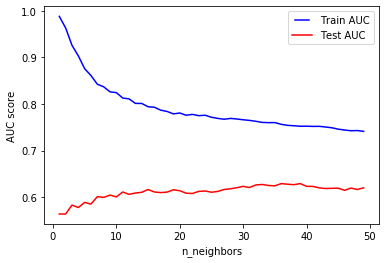

In [8]:
line1, = plt.plot(neighbors, train_results,  c='b', label='Train AUC')
line2, = plt.plot(neighbors, test_results, c='r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.savefig('plots/KNN_AUC_2.png')
plt.show()

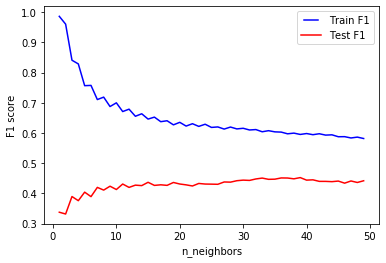

In [9]:
line1, = plt.plot(neighbors, train_results_f1, c='b', label='Train F1')
line2, = plt.plot(neighbors, test_results_f1, c='r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_neighbors')
plt.savefig('plots/KNN_F1_2.png')
plt.show()

In [10]:
print(max(test_results))
print(test_results.index(max(test_results)))
print(max(test_results_f1))
print(test_results_f1.index(max(test_results_f1)))

0.628945351968779
38
0.45258783528522856
38


In [19]:
knn = KNeighborsClassifier(n_neighbors=38)
knn.fit(X_train_delta_upsampled, y_train_delta_upsampled)
y_pred = knn.predict(X_test_delta)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      3126
           1       0.37      0.56      0.45      1022

    accuracy                           0.66      4148
   macro avg       0.60      0.63      0.60      4148
weighted avg       0.72      0.66      0.68      4148



### Fine tuning for SVM

In [69]:
Cs = [0.01, 0.1, 1]
gammas = ['scale']
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
class_weights = [{1:0.75, 0:25}]
param_grid = {'C': Cs, 'gamma' : gammas, 'kernel':kernels, 'class_weight':class_weights}

svm = SVC()
# Instantiate the grid search model
grid_svm = GridSearchCV(estimator = svm, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='f1')
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/jiankun/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1],
                         'class_weight': [{0: 25, 1: 0.75}], 'gamma': ['scale'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=2)

In [70]:
best_para = grid_svm.best_params_
print(best_para)
svm = SVC()
svm.set_params(**best_para)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

{'C': 1, 'class_weight': {1: 0.75, 0: 25}, 'gamma': 'scale', 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3126
           1       0.69      0.03      0.06      1022

    accuracy                           0.76      4148
   macro avg       0.73      0.51      0.46      4148
weighted avg       0.74      0.76      0.66      4148



In [6]:
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      3126
           1       0.00      0.00      0.00      1022

    accuracy                           0.75      4148
   macro avg       0.38      0.50      0.43      4148
weighted avg       0.57      0.75      0.65      4148



/home/jiankun/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
svm = SVC(class_weight = {1:0.75,0:0.25},kernel = 'linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      3126
           1       0.36      0.56      0.44      1022

    accuracy                           0.65      4148
   macro avg       0.60      0.62      0.59      4148
weighted avg       0.71      0.65      0.67      4148



In [76]:
svm = SVC(class_weight = {1:0.75,0:0.25},kernel = 'rbf')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      3126
           1       0.44      0.61      0.51      1022

    accuracy                           0.71      4148
   macro avg       0.64      0.68      0.65      4148
weighted avg       0.75      0.71      0.72      4148



### Fine tuning for Logistic regression

In [45]:
penalty = ['l1', 'l2']
C_param_range = [0.001,0.1,1,10]

# Create hyperparameter options
hyperparameters = dict(C=C_param_range, penalty=penalty)

logi = LogisticRegression()
# Instantiate the grid search model
grid_logi = GridSearchCV(estimator = logi, param_grid = hyperparameters, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='roc_auc')
grid_logi.fit(X_train_delta_upsampled, y_train_delta_upsampled)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s finished
/home/jiankun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=2)

In [49]:
best_para = grid_logi.best_params_
print(best_para)
lg = LogisticRegression()
lg.set_params(**best_para)
lg.fit(X_train_delta_upsampled, y_train_delta_upsampled)
y_pred = lg.predict(X_test_delta)
print(classification_report(y_test, y_pred))

{'C': 0.1, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.84      0.56      0.67      3126
           1       0.33      0.67      0.44      1022

    accuracy                           0.59      4148
   macro avg       0.58      0.61      0.56      4148
weighted avg       0.71      0.59      0.61      4148



/home/jiankun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
model = SVC(class_weight = {1:0.75,0:0.25},probability=True)
model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight={0: 0.25, 1: 0.75}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [16]:
y_pred = model.predict_proba(X_test)[:,1]

In [18]:
E = pd.read_csv('../data/Study_E.csv')
X_E = E.iloc[:, 7:38]
X_E = ss_X.fit_transform(X_E)


In [19]:
y_pred = model.predict_proba(X_E)[:,1]

In [23]:
df_out = pd.DataFrame()
df_out['AssessmentID']=E['AssessmentiD']
df_out['LeadStatus'] = y_pred
df_out.head()

,AssessmentID,LeadStatus
0,501017,0.0
1,500679,0.0
2,500930,0.0
3,502177,0.0
4,501533,0.0


In [24]:
df_out.to_csv('submission.csv',index=False)